In [1]:
# -----------------------------
# Cell 1: Setup paths
# -----------------------------
import sys
from pathlib import Path

# Notebook location
notebook_path = Path().resolve()  # current notebook folder
project_root = notebook_path.parent.parent  # Notebook/ -> project root
src_path = project_root / "src"


# Current notebook folder
notebook_path = Path().resolve()


# Add to Python path
sys.path.insert(0, str(src_path))
sys.path.insert(0, str(project_root))

print("Notebook path:", notebook_path)
print("Project root:", project_root)
print("SRC path:", src_path)

Notebook path: D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics\notebooks\analysis
Project root: D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics
SRC path: D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics\src


In [2]:
# Basic imports
import pandas as pd
import logging

# Project modules
from fintech_app_reviews.config import load_config
from fintech_app_reviews.nlp.sentiment import annotate_dataframe, aggregate_sentiment
from fintech_app_reviews.nlp.keywords import extract_tfidf_keywords_per_group, attach_top_keywords_to_df
from fintech_app_reviews.nlp.themes import map_keywords_to_themes
from fintech_app_reviews.viz.plots import plot_sentiment_distribution, plot_sentiment_by_group, plot_theme_counts

# Logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(levelname)s %(message)s")
logger = logging.getLogger(__name__)

In [3]:
# Config path at project root
config_path = project_root / "configs" / "nlp.yaml"

# Load NLP config
nlp_cfg = load_config(config_path)

print("Config path:", config_path)

# Load cleaned reviews
df = pd.read_csv(project_root / "data/interim/clean_reviews.csv")
print(f"Loaded {len(df)} reviews")
df.head()

Config path: D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics\configs\nlp.yaml
Loaded 1374 reviews


,review,rating,date,bank,source
0,it's special for me,5,2025-11-29,Commercial Bank of Ethiopia (CBE),google_play
1,this application is very important and advanta...,5,2025-11-27,Commercial Bank of Ethiopia (CBE),google_play
2,why didn't work this app?,1,2025-11-27,Commercial Bank of Ethiopia (CBE),google_play
3,the app makes our life easier. thank you cbe!,5,2025-11-27,Commercial Bank of Ethiopia (CBE),google_play
4,the most advanced app. but how to stay safe?,5,2025-11-27,Commercial Bank of Ethiopia (CBE),google_play


In [4]:
# Ensure the directory exists
sentiment_csv = project_root / "data/processed/reviews_with_sentiment.csv"
# Save sentiment results
df.to_csv(sentiment_csv, index=False)
logger.info("Saved sentiment results to %s", sentiment_csv)

INFO:__main__:Saved sentiment results to D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics\data\processed\reviews_with_sentiment.csv


In [8]:
if nlp_cfg.get('keywords', {}).get('enabled', False):
    try:
        # Extract top TF-IDF keywords per bank
        top_keywords_dict = extract_tfidf_keywords_per_group(
            df,
            text_col="review",
            group_col="bank",
            top_n=nlp_cfg['keywords']['tfidf']['top_n'],
            ngram_range=tuple(nlp_cfg['keywords']['tfidf']['ngram_range'])
        )
        # Attach keywords to df
        df, _ = attach_top_keywords_to_df(
            df,
            text_col="review",
            global_tfidf=sum(top_keywords_dict.values(),
                             [])  # flatten all groups
        )
        logger.info("Keyword extraction complete")
        df[['review', 'keywords']].head()
    except Exception as e:
        logger.exception("Keyword extraction failed: %s", e)

INFO:__main__:Keyword extraction complete


In [9]:
if nlp_cfg.get('themes', {}).get('enabled', False):
    try:
        # Convert keyword strings to list for theme mapping
        def safe_map_keywords_to_themes(kw_str):
            if not kw_str:
                return []
            if isinstance(kw_str, str):
                kw_list = kw_str.split("|")
            else:
                kw_list = list(kw_str)
            return map_keywords_to_themes(kw_list)

        df['themes'] = df['keywords'].apply(safe_map_keywords_to_themes)
        logger.info("Theme mapping complete")
        df[['review', 'keywords', 'themes']].head()
    except Exception as e:
        logger.exception("Theme mapping failed: %s", e)

INFO:__main__:Theme mapping complete


In [12]:
if nlp_cfg.get('sentiment', {}).get('enabled', False):
    try:
        # Annotate sentiment using VADER
        df = annotate_dataframe(df, text_col="review")
        logger.info("Sentiment annotation complete")
        df[['review', 'sentiment_label', 'sentiment_score']].head()

        # Save sentiment CSV
        
        sentiment_path = project_root/"data/processed/reviews_with_sentiment.csv"

        df.to_csv(sentiment_path, index=False)
        logger.info("Saved sentiment results to %s", sentiment_path)

    except Exception as e:
        logger.exception("Sentiment analysis failed: %s", e)

INFO:fintech_app_reviews.nlp.sentiment:VADER Sentiment Analyzer initialized
INFO:fintech_app_reviews.nlp.sentiment:Processing row 0/1374
INFO:fintech_app_reviews.nlp.sentiment:Processing row 100/1374
INFO:fintech_app_reviews.nlp.sentiment:Processing row 200/1374
INFO:fintech_app_reviews.nlp.sentiment:Processing row 300/1374
INFO:fintech_app_reviews.nlp.sentiment:Processing row 400/1374
INFO:fintech_app_reviews.nlp.sentiment:Processing row 500/1374
INFO:fintech_app_reviews.nlp.sentiment:Processing row 600/1374
INFO:fintech_app_reviews.nlp.sentiment:Processing row 700/1374
INFO:fintech_app_reviews.nlp.sentiment:Processing row 800/1374
INFO:fintech_app_reviews.nlp.sentiment:Processing row 900/1374
INFO:fintech_app_reviews.nlp.sentiment:Processing row 1000/1374
INFO:fintech_app_reviews.nlp.sentiment:Processing row 1100/1374
INFO:fintech_app_reviews.nlp.sentiment:Processing row 1200/1374
INFO:fintech_app_reviews.nlp.sentiment:Processing row 1300/1374
INFO:__main__:Sentiment annotation compl

In [13]:
# -----------------------------
# Keyword Extraction
# -----------------------------
if nlp_cfg.get('keywords', {}).get('enabled', False):
    try:
        # Extract TF-IDF keywords per bank
        tfidf_cfg = nlp_cfg['keywords'].get(
            'tfidf', {'top_n': 20, 'ngram_range': [1, 2]})
        bank_keywords = extract_tfidf_keywords_per_group(
            df,
            text_col='review',
            group_col='bank',
            top_n=tfidf_cfg['top_n'],
            ngram_range=tuple(tfidf_cfg['ngram_range'])
        )

        # Flatten keywords for global matching
        global_keywords = list(
            {kw for kws in bank_keywords.values() for kw in kws})

        # Attach keywords to each review
        df, _ = attach_top_keywords_to_df(
            df,
            text_col='review',
            top_k=tfidf_cfg.get('top_k', 5),
            global_tfidf=global_keywords
        )

        logger.info("Keyword extraction complete")
        df[['review', 'keywords']].head()

    except Exception as e:
        logger.exception("Keyword extraction failed: %s", e)

INFO:__main__:Keyword extraction complete


In [15]:
# -----------------------------
# Theme Mapping
# -----------------------------
if nlp_cfg.get('themes', {}).get('enabled', False):
    try:
        # Apply theme mapping using internal THEME_KEYWORDS
        df['themes'] = df['keywords'].apply(map_keywords_to_themes)
        logger.info("Theme mapping complete")
        df[['review', 'keywords', 'themes']].head()

    except Exception as e:
        logger.exception("Theme mapping failed: %s", e)
 # Save themed reviews
themes_csv = project_root/"data/processed/reviews_with_themes.csv"
df.to_csv(themes_csv, index=False)
logger.info("Saved reviews with themes to %s", themes_csv)

df.head()

INFO:__main__:Theme mapping complete
INFO:__main__:Saved reviews with themes to D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics\data\processed\reviews_with_themes.csv


,review,rating,date,bank,source,keywords,themes,sentiment_label,sentiment_score
0,it's special for me,5,2025-11-29,Commercial Bank of Ethiopia (CBE),google_play,,[],positive,0.4019
1,this application is very important and advanta...,5,2025-11-27,Commercial Bank of Ethiopia (CBE),google_play,application|money|transfer|app,[],positive,0.5198
2,why didn't work this app?,1,2025-11-27,Commercial Bank of Ethiopia (CBE),google_play,work|app,[],neutral,0.0000
3,the app makes our life easier. thank you cbe!,5,2025-11-27,Commercial Bank of Ethiopia (CBE),google_play,life|make|thank|cbe|app,[],positive,0.6800
4,the most advanced app. but how to stay safe?,5,2025-11-27,Commercial Bank of Ethiopia (CBE),google_play,app,[],positive,0.6701


In [16]:
agg_df = aggregate_sentiment(df, group_cols=nlp_cfg['sentiment'].get(
    'aggregate_by', ["bank", "rating"]))
agg_df.head()

,bank,rating,mean_sentiment_score,positive_count,negative_count,neutral_count
0,Bank of Abyssinia (BOA),1,-0.206462,44,119,57
1,Bank of Abyssinia (BOA),2,0.030452,8,7,10
2,Bank of Abyssinia (BOA),3,0.139061,20,7,6
3,Bank of Abyssinia (BOA),4,0.284891,15,2,6
4,Bank of Abyssinia (BOA),5,0.353441,131,7,47


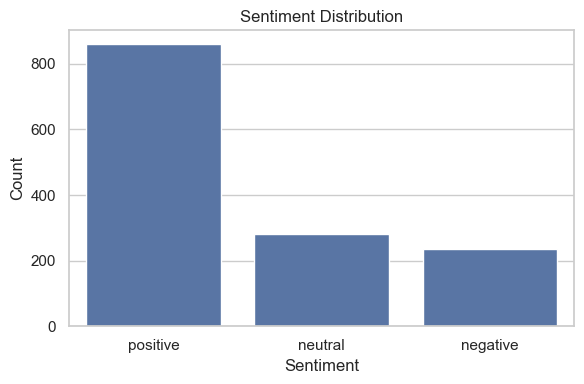

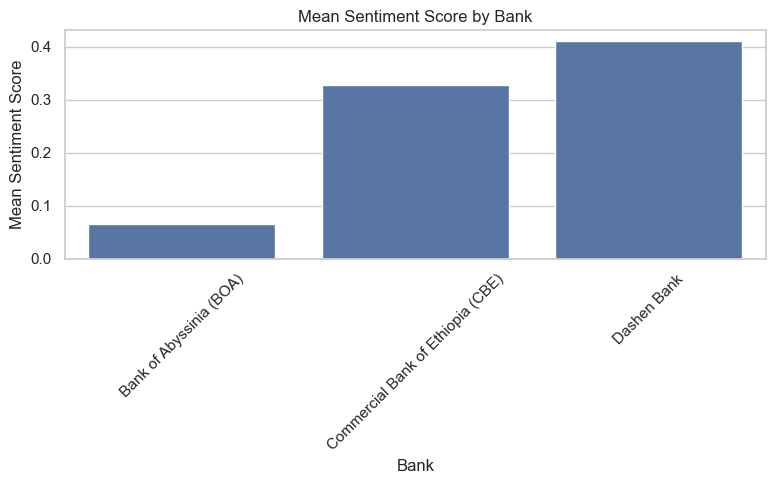

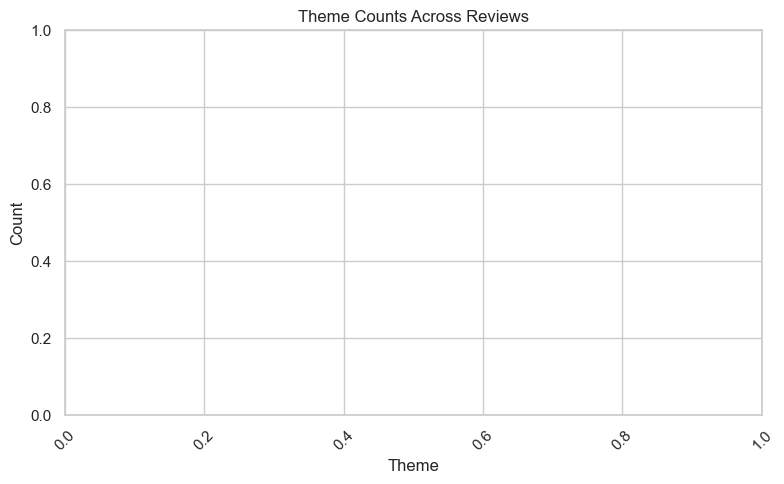

In [17]:
# Plot sentiment distribution
plot_sentiment_distribution(df, sentiment_col="sentiment_label")

# Plot mean sentiment per bank
plot_sentiment_by_group(df, group_col="bank",
                        sentiment_score_col="sentiment_score")

# Plot theme counts
plot_theme_counts(df, theme_col="themes")